## Learning a standard PyTorch workflow (it can be chopped and changed as necessary but it covers the main outline of steps)

In [ ]:
# Import pytorch and matplotlib
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Create weight and bias
weight = 0.3
bias = 0.9

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)  # without unsqueeze errors will occur later (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.9000],
         [0.9060],
         [0.9120],
         [0.9180],
         [0.9240],
         [0.9300],
         [0.9360],
         [0.9420],
         [0.9480],
         [0.9540]]))

In [ ]:
# Split data 80, 20
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

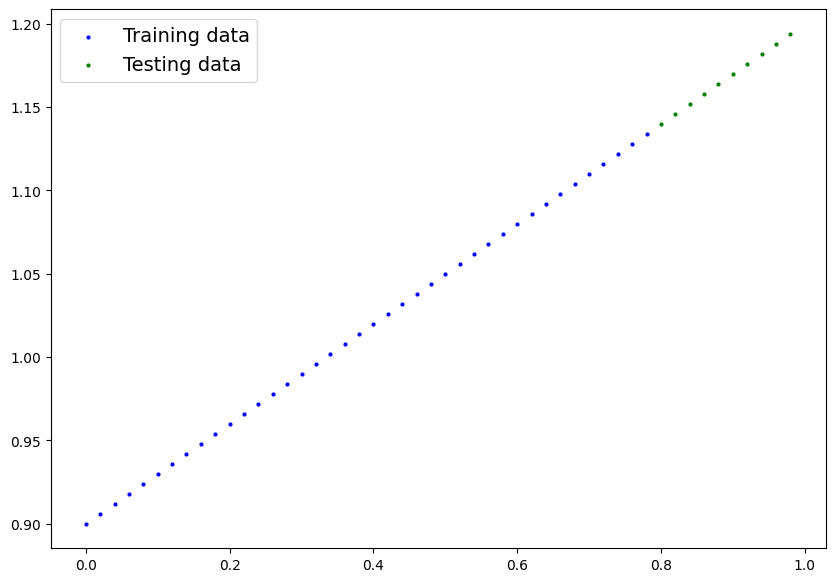

In [ ]:
# Create a function to visualize it
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  # Plots training data, test data, and compares predictions
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Plot predictions in red (predictions were made on the test data)
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show a legend
  plt.legend(prop={"size": 14});

#plot_predictions();  # same as below
plot_predictions(X_train, y_train, X_test, y_test)

In [ ]:
# Subclass nn.Module to make our model
class LinRegModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating model params
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  # Define the forward computation (input data x flows through nn.Linear())
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed when creating the model (isn't always needed)
#torch.manual_seed(42)
model_2 = LinRegModel()
model_2, model_2.state_dict()

(LinRegModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.2191]])),
              ('linear_layer.bias', tensor([0.2018]))]))

In [ ]:
# Check model device
next(model_2.parameters()).device

device(type='cpu')

In [ ]:
# Set model to GPU if available
model_2.to(device)
next(model_2.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Create loss function
loss_func = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(),  # optimize model's params
                            lr=0.01)

In [ ]:
#torch.manual_seed(42)

# Set number of epochs
epochs = 300

# Put data on available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_2.train()  # train mode is on by default after construction

  # 1. Forward pass
  y_pred = model_2(X_train)

  # 2. Calculate loss
  loss = loss_func(y_pred, y_train)

  # 3. Zero grad optimizer
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_2.eval()  # put model in eval mode for testing (inference)

  # 1. Forward pass
  with torch.inference_mode():
    test_pred = model_2(X_test)

    # 2. Calculate loss
    test_loss = loss_func(test_pred, y_test)

  if epoch % 20 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Train loss: 0.9006596803665161 | Test loss: 1.146740436553955
Epoch: 20 | Train loss: 0.6702397465705872 | Test loss: 0.8773204684257507
Epoch: 40 | Train loss: 0.43981996178627014 | Test loss: 0.6079007387161255
Epoch: 60 | Train loss: 0.20940016210079193 | Test loss: 0.3384808897972107
Epoch: 80 | Train loss: 0.044915661215782166 | Test loss: 0.12189526855945587
Epoch: 100 | Train loss: 0.03370872884988785 | Test loss: 0.07914894074201584
Epoch: 120 | Train loss: 0.02681274153292179 | Test loss: 0.06226086616516113
Epoch: 140 | Train loss: 0.0199471116065979 | Test loss: 0.04571627452969551
Epoch: 160 | Train loss: 0.013082302175462246 | Test loss: 0.029858505353331566
Epoch: 180 | Train loss: 0.006208822131156921 | Test loss: 0.014000666327774525
Epoch: 200 | Train loss: 0.003958422224968672 | Test loss: 0.005028415005654097
Epoch: 220 | Train loss: 0.003958422224968672 | Test loss: 0.005028415005654097
Epoch: 240 | Train loss: 0.003958422224968672 | Test loss: 0.00502841

In [ ]:
# Display model's learned params
from pprint import pprint
print("The model learned the following values for weights and bias:")
pprint(model_2.state_dict())
print("\nAnd the original values and weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.2910]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8995], device='cuda:0'))])

And the original values and weights and bias are:
weights: 0.3, bias: 0.9


In [ ]:
# Turn model into eval mode
model_2.eval()

# Make predictions on test data
with torch.inference_mode():
  y_preds = model_2(X_test)

y_preds

tensor([[1.1324],
        [1.1382],
        [1.1440],
        [1.1498],
        [1.1556],
        [1.1615],
        [1.1673],
        [1.1731],
        [1.1789],
        [1.1848]], device='cuda:0')

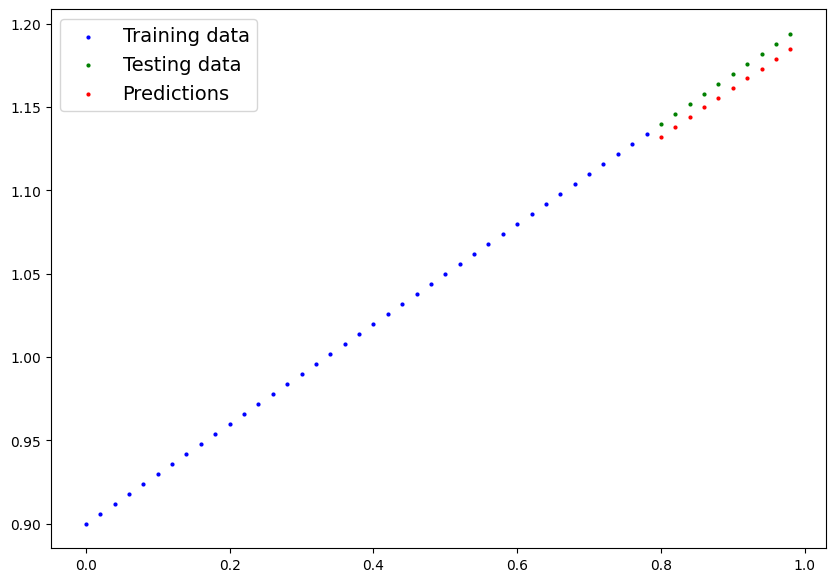

In [ ]:
# Put data on CPU and plot it
plot_predictions(predictions=y_preds.cpu())

In [ ]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "01_pytorch_exercies_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_exercies_model_2.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1744 Mar 28 19:15 01_pytorch_exercies_model_2.pth


In [ ]:
# Instantiate a new instance of LinRegModel
loaded_model_2 = LinRegModel()

# Load model state dict
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model on target device
loaded_model_2.to(device)

print(f"Loaded model:\n{loaded_model_2}")
print(f"Model on device:\n{next(loaded_model_2.parameters()).device}")

Loaded model:
LinRegModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [ ]:
# Evaluate loaded model
loaded_model_2.eval()
with torch.inference_mode():
  loaded_model_2_preds = loaded_model_2(X_test)

y_preds == loaded_model_2_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

In [ ]:
from google.colab import runtime
runtime.unassign()